In this notebook we check how the popularity of ML was changing for different astronomical topics. The topics are determined from keywords, which is far from the optimal way: many papers do not have keywords, or they do not describe the content of the paper competely, and these biases are topic-dependent. In other notebooks we try to do similar evaluation from titles and abstracts. However, the best way would be to do a full-scale NLP analysis.

The algorithm:

    for year in years:
    
        keywords=request(keywords for all refereed papers with "machine learning" in abstract)
        
        counts = count(keywords frequency)
        
        countsNorm=counts/counts(all papers with this keyword)

In [1]:
import pandas as pd
from collections import Counter
import requests
from typing import Dict, Tuple,List
import matplotlib.pyplot as plt
import os

In [2]:
tokenFile='token.ini'
dirData='data'

In [22]:
# Converts params from human-readable tuple into url request form
def setParams(searchCriteria: Tuple,maxRows: int=None):
    searchCriteria=searchCriteria
    params=[('fq',q) for q in searchCriteria]
    params[0]=('q',params[0][1])
    flags=[('fl','keyword')]
    if maxRows:
        rows=[('rows',str(int(maxRows)))]
    else:
        rows=[('rows',str(int(2000)))]
    params=tuple(params+rows+flags)
    return params

In [4]:
# Parameters for requests. The token can be obtained via Ads Settings->API Token
with open(tokenFile) as f:
    token = str(f.readline()).rstrip()
AdsUrl='https://api.adsabs.harvard.edu/v1/search/query'
headers = {'Authorization': 'Bearer '+token}

In [5]:
# Making a request with some additional specifier
def requestCounts(year: int, additional: str='')->int:
    searchCriteria=('year:'+str(year),'database:astronomy',
                    'property:refereed','abs:"machine learning"', additional)
    if additional!='':
        searchCriteria=searchCriteria+(additional,)
    params=setParams(searchCriteria,maxRows=10)
    response = requests.get(url=AdsUrl, headers=headers, params=params)
    count=response.json()['response']['numFound']
    return count

In [6]:
def responseToPandas(response: list):
    df=pd.DataFrame(columns=['keyword'])
    for rec in response:
        df=df.append(rec,ignore_index=True)
    return df

In [7]:
topics=['Earth','Solar','Exoplanet','Galaxy','cosmology','Gravitational Waves','High Energy',
'ISM','Sun','asteroids','binaries','galaxies','gravitational lensing',
'large-scale structure','stars','supernovae','quasars','pulsar','planets and satellites']
topics=[t.lower() for t in topics]
common=['survey','catalog','technique','method','machine learning','computer science']

In [30]:
def request(year: int,additional:str=''):
    searchCriteria=('year:'+str(year),'database:astronomy','property:refereed','abs:"machine learning"')
    if additional!='':
        searchCriteria=searchCriteria+(additional,)
    params=setParams(searchCriteria)
    response = requests.get(url=AdsUrl, headers=headers, params=params)
    df=responseToPandas(response.json()['response']['docs'])
    return df

In [31]:
# Count total number of keywords in the papers
def getKeywords(df):
    keywords=[]
    for k in df['keyword']:
        if type(k)==list:
            keywords=keywords+k
    keywordsCount=pd.DataFrame(columns=['keyword','count'])
    keywordsCount['keyword']=Counter(keywords).keys()
    keywordsCount['count']=Counter(keywords).values()
    keywordsCount['keyword']=keywordsCount['keyword'].map(lambda s: s.lower())
    return keywordsCount

In [32]:
### For checking year by year if I missed any topic words ###
def checkNewKeywords(keywordsCount,topics,common):
    mask=keywordsCount['keyword'].map(lambda row: any([topic in row for topic in common]))
    keywordWork=keywordsCount[~mask]
    mask=keywordWork['keyword'].map(lambda row: any([topic in row for topic in topics]))
    keywordWork=keywordWork[~mask]
    keywordWork.sort_values('count',ascending=False)
    return keywordWork

In [33]:
# Count keywords that are in pre-defined list 'topics'
def getTopics(keywordsCount,topics):
    mask=keywordsCount['keyword'].map(lambda row: any([topic in row for topic in topics]))
    keywordWork=keywordsCount[mask]
    topicsCount={}
    for topic in topics:
        df=keywordsCount[keywordsCount['keyword'].map(lambda row: topic in row)]
        topicsCount[topic]=df['count'].sum()
    return topicsCount

In [35]:
statByYears=pd.DataFrame(columns=['year']+topics)
years=range(2010,2021)
for year in years:
    print(year)
    df=request(year)
    keywordsCount=getKeywords(df)
    topicsCount=getTopics(keywordsCount,topics)
    topicsCount['year']=year
    statByYears=statByYears.append(topicsCount,ignore_index=True)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [36]:
# Sum some keywords frequency
statByYears['sun_total']=statByYears['sun']+statByYears['solar']
statByYears['exoplanets_total']=statByYears['exoplanet']+statByYears['planets and satellites']

In [37]:
statByYears

,year,earth,solar,exoplanet,galaxy,cosmology,gravitational waves,high energy,ism,sun,...,galaxies,gravitational lensing,large-scale structure,stars,supernovae,quasars,pulsar,planets and satellites,sun_total,exoplanets_total
0,2010,1,5,0,1,3,0,0,1,3,...,5,0,1,2,0,0,0,0,8,0
1,2011,0,0,0,1,4,0,1,1,0,...,1,0,0,0,0,1,0,0,0,0
2,2012,2,2,0,0,6,0,2,0,0,...,13,0,1,8,1,1,1,0,2,0
3,2013,0,3,0,1,6,0,4,0,6,...,16,0,1,10,1,2,1,0,9,0
4,2014,1,6,0,1,12,1,5,1,0,...,21,2,0,9,1,1,3,0,6,0
5,2015,1,13,0,5,18,0,5,6,8,...,26,1,2,10,3,2,0,1,21,1
6,2016,7,12,1,2,26,0,6,3,3,...,55,0,5,28,5,3,4,4,15,5
7,2017,8,11,1,5,18,1,5,6,15,...,39,2,2,19,3,2,1,2,26,3
8,2018,21,27,0,11,25,2,17,11,8,...,113,4,6,46,1,9,4,8,35,8
9,2019,20,37,0,17,55,1,38,19,11,...,151,9,8,32,5,8,2,15,48,15


In [38]:
cols=list(statByYears.columns)
cols=[col for col in cols if col not in ['year','solar','sun','exoplanet','planets and satellites']]

In [39]:
import matplotlib.pyplot as plt

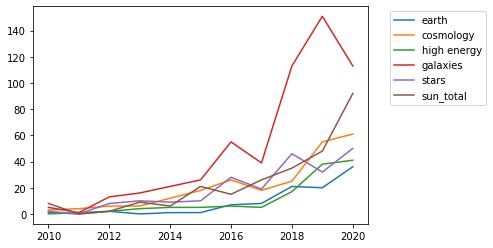

In [40]:
for col in cols:
    if any(statByYears[statByYears['year']==2020][col]>20):
        plt.plot(statByYears['year'],statByYears[col],label=col)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

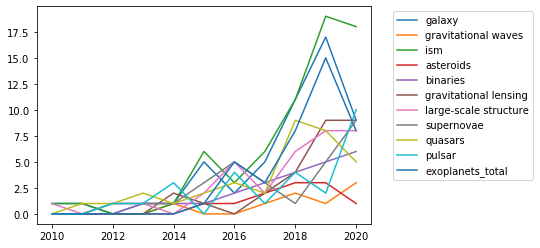

In [41]:
for col in cols:
    if any(statByYears[statByYears['year']==2020][col]<=20):
        plt.plot(statByYears['year'],statByYears[col],label=col)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [42]:
statByYears.to_csv(os.path.join(dirData,'topicsFromKeywords.csv'),index=False)

In [43]:
### check total number of papers with given keywords ###
statByYearsTotal=pd.DataFrame(columns=['year']+topics)
for year in years:
    print(year)
    counts={'year':year}
    for topic in topics:
        c=requestCounts(year,additional='keyword:"'+topic+'"')
        counts[topic]=c

    statByYearsTotal=statByYearsTotal.append(counts,ignore_index=True)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [44]:
statByYearsTotal['sun_total']=statByYearsTotal['sun']+statByYearsTotal['solar']
statByYearsTotal['exoplanets_total']=statByYearsTotal['exoplanet']+statByYearsTotal['planets and satellites']

In [47]:
statByYears

,year,earth,solar,exoplanet,galaxy,cosmology,gravitational waves,high energy,ism,sun,...,galaxies,gravitational lensing,large-scale structure,stars,supernovae,quasars,pulsar,planets and satellites,sun_total,exoplanets_total
0,2010,1,5,0,1,3,0,0,1,3,...,5,0,1,2,0,0,0,0,8,0
1,2011,0,0,0,1,4,0,1,1,0,...,1,0,0,0,0,1,0,0,0,0
2,2012,2,2,0,0,6,0,2,0,0,...,13,0,1,8,1,1,1,0,2,0
3,2013,0,3,0,1,6,0,4,0,6,...,16,0,1,10,1,2,1,0,9,0
4,2014,1,6,0,1,12,1,5,1,0,...,21,2,0,9,1,1,3,0,6,0
5,2015,1,13,0,5,18,0,5,6,8,...,26,1,2,10,3,2,0,1,21,1
6,2016,7,12,1,2,26,0,6,3,3,...,55,0,5,28,5,3,4,4,15,5
7,2017,8,11,1,5,18,1,5,6,15,...,39,2,2,19,3,2,1,2,26,3
8,2018,21,27,0,11,25,2,17,11,8,...,113,4,6,46,1,9,4,8,35,8
9,2019,20,37,0,17,55,1,38,19,11,...,151,9,8,32,5,8,2,15,48,15


In [46]:
statByYearsTotal

,year,earth,solar,exoplanet,galaxy,cosmology,gravitational waves,high energy,ism,sun,...,galaxies,gravitational lensing,large-scale structure,stars,supernovae,quasars,pulsar,planets and satellites,sun_total,exoplanets_total
0,2010,1,3,0,4,3,0,0,0,3,...,4,0,1,3,0,0,0,0,6,0
1,2011,0,0,0,4,3,0,1,0,0,...,4,0,0,0,0,1,0,0,0,0
2,2012,2,2,0,6,5,0,2,0,2,...,6,0,1,7,1,1,1,0,4,0
3,2013,0,4,0,10,6,1,3,0,4,...,10,0,1,6,1,2,1,0,8,0
4,2014,1,6,0,14,9,1,4,1,6,...,14,2,0,10,1,1,3,0,12,0
5,2015,1,12,0,26,17,1,4,2,12,...,26,1,2,12,3,2,0,1,24,1
6,2016,6,11,1,34,20,0,7,2,11,...,34,0,5,21,5,2,4,3,22,4
7,2017,3,10,1,28,15,1,4,2,10,...,28,2,2,22,3,2,1,1,20,2
8,2018,14,26,0,65,23,2,16,6,26,...,65,4,6,40,1,6,4,6,52,6
9,2019,16,36,0,90,42,1,30,9,36,...,90,8,8,52,4,8,2,11,72,11


In [54]:
statByYearsTotal=statByYearsTotal.astype(int)
statByYears=statByYears.astype(int)
statByYearsRatio=statByYears.divide(statByYearsTotal,fill_value=0)

In [58]:
import numpy as np

In [64]:
statByYearsRatio=statByYearsRatio.replace([np.inf, -np.inf], np.nan)
statByYearsRatio=statByYearsRatio.fillna(0)
statByYearsRatio['year']=statByYears['year']

In [65]:
statByYearsRatio

,year,earth,solar,exoplanet,galaxy,cosmology,gravitational waves,high energy,ism,sun,...,galaxies,gravitational lensing,large-scale structure,stars,supernovae,quasars,pulsar,planets and satellites,sun_total,exoplanets_total
0,2010,1.000000,1.666667,0.0,0.250000,1.000000,0.0,0.000000,0.000000,1.000000,...,1.250000,0.000,1.0,0.666667,0.000,0.000000,0.0,0.000000,1.333333,0.000000
1,2011,0.000000,0.000000,0.0,0.250000,1.333333,0.0,1.000000,0.000000,0.000000,...,0.250000,0.000,0.0,0.000000,0.000,1.000000,0.0,0.000000,0.000000,0.000000
2,2012,1.000000,1.000000,0.0,0.000000,1.200000,0.0,1.000000,0.000000,0.000000,...,2.166667,0.000,1.0,1.142857,1.000,1.000000,1.0,0.000000,0.500000,0.000000
3,2013,0.000000,0.750000,0.0,0.100000,1.000000,0.0,1.333333,0.000000,1.500000,...,1.600000,0.000,1.0,1.666667,1.000,1.000000,1.0,0.000000,1.125000,0.000000
4,2014,1.000000,1.000000,0.0,0.071429,1.333333,1.0,1.250000,1.000000,0.000000,...,1.500000,1.000,0.0,0.900000,1.000,1.000000,1.0,0.000000,0.500000,0.000000
5,2015,1.000000,1.083333,0.0,0.192308,1.058824,0.0,1.250000,3.000000,0.666667,...,1.000000,1.000,1.0,0.833333,1.000,1.000000,0.0,1.000000,0.875000,1.000000
6,2016,1.166667,1.090909,1.0,0.058824,1.300000,0.0,0.857143,1.500000,0.272727,...,1.617647,0.000,1.0,1.333333,1.000,1.500000,1.0,1.333333,0.681818,1.250000
7,2017,2.666667,1.100000,1.0,0.178571,1.200000,1.0,1.250000,3.000000,1.500000,...,1.392857,1.000,1.0,0.863636,1.000,1.000000,1.0,2.000000,1.300000,1.500000
8,2018,1.500000,1.038462,0.0,0.169231,1.086957,1.0,1.062500,1.833333,0.307692,...,1.738462,1.000,1.0,1.150000,1.000,1.500000,1.0,1.333333,0.673077,1.333333
9,2019,1.250000,1.027778,0.0,0.188889,1.309524,1.0,1.266667,2.111111,0.305556,...,1.677778,1.125,1.0,0.615385,1.250,1.000000,1.0,1.363636,0.666667,1.363636


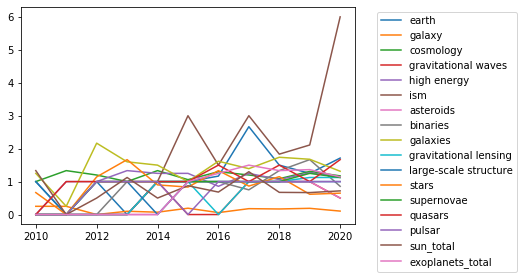

In [66]:
for col in cols:
    plt.plot(statByYearsRatio['year'],statByYearsRatio[col],label=col)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')